## GB_Fx-Quarterly_panel



[notice] A new release of pip is available: 24.3.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


Data (B): 2000-01-31 → 2025-11-10 | n=6726
Data (D): 2000-01-31 → 2025-11-10 | n=9416
Columns (DF_d): ['EUR_NOK', 'OSEBX', 'SP500', 'OBX_Energy', 'Brent', 'Q', 'dI_t', 'VIX', 'StoxEurope', 'd_pi']

Dropped quarters and reasons:
  2000Q1: no_cut_in_prev_quarter
  2000Q2: hist<400
  2000Q3: hist<400
  2000Q4: hist<400
  2001Q1: hist<400

=== Model performance (quarterly mean, EUR/NOK – GB panel + past macro covariates) ===
Observations: 99
RMSE (level): 0.246577
MAE  (level): 0.177276
Directional accuracy: 70/98 (71.4%)

=== Diebold–Mariano vs Random Walk (GB panel setup, quarterly) ===
Loss: MSE | horizon h=1
DM-statistic: 0.2000
p-value     : 0.8415


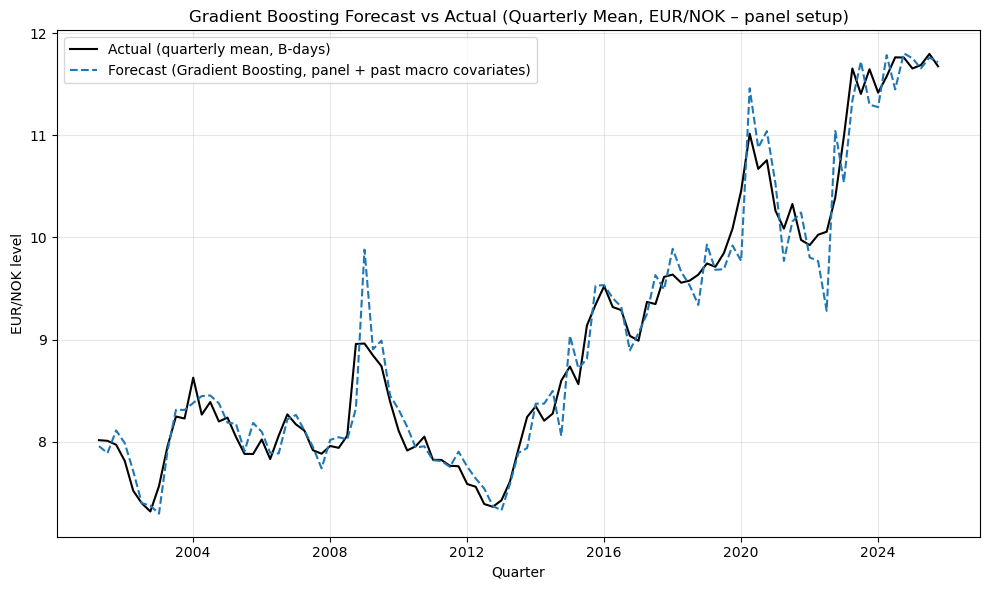

Saved: GB_Q_daily_panel_pastcov.png
Saved: GB_Q_daily_panel_pastcov.pdf


In [6]:
# =========================================
# Gradient Boosting – EUR/NOK walk-forward (quarterly, levels) with daily panel + macro covariates
# PARALLEL OUTER LOOP
# Cross-learning analogue for GB:
#   - Target: EUR_NOK (single series)
#   - Panel predictors: Brent, VIX, StoxEurope, SP500, OSEBX, OBX_Energy + EUR_NOK lags
#   - Macros: Q, d_pi, dI_t as past-only covariates
#   - Data: daily (calendar days), forward-filled
#   - Cut: last business day of previous quarter (based on EUR_NOK B-days)
#   - Forecast: recursive daily next-quarter -> aggregate to quarterly mean over business days
#   - No future covariate paths -> all non-target predictors frozen at last observed level
#   - Metrics: Observations, RMSE, MAE, Directional accuracy
#   - Test: Diebold–Mariano vs Random Walk (MSE, h=1)
#   - Plot: Actual (black) vs Forecast (blue dashed), no intervals
# =========================================

!pip -q install pandas numpy scikit-learn matplotlib requests certifi joblib

from __future__ import annotations
import io, time, math
from dataclasses import dataclass
from typing import Optional, Tuple, Dict, List

import numpy as np
import pandas as pd
import requests, certifi
import matplotlib.pyplot as plt

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error
from joblib import Parallel, delayed

# -----------------------------
# Configuration
# -----------------------------
@dataclass
class Config:
    url: str = (
        "https://raw.githubusercontent.com/bredeespelid/"
        "Data_MasterOppgave/refs/heads/main/Variables/All_Variables/variables_daily.csv"
    )
    q_freq: str = "Q-DEC"      # Quarterly evaluation
    min_hist_days: int = 400   # More history for stable GB with many predictors
    max_lags: int = 20         # Number of daily lags for each predictor
    max_horizon: int = 128     # Must exceed longest quarter (~92 days)

    # Gradient Boosting hyperparameters
    n_estimators: int = 1800
    learning_rate: float = 0.03
    max_depth: int = 3
    subsample: float = 0.8
    min_samples_leaf: int = 2
    random_state: int = 42

    retries: int = 3
    timeout: int = 60
    verbose: bool = True
    fig_png: str = "GB_Q_daily_panel_pastcov.png"
    fig_pdf: str = "GB_Q_daily_panel_pastcov.pdf"

CFG = Config()

TARGET_SERIES = "EUR_NOK"
PANEL_SERIES = [
    "EUR_NOK",
    "Brent",
    "VIX",
    "StoxEurope",
    "SP500",
    "OSEBX",
    "OBX_Energy",
]
MACRO_COLS = ["Q", "d_pi", "dI_t"]

ALL_PREDICTORS = PANEL_SERIES + MACRO_COLS  # All used as lagged predictors

# -----------------------------
# Download helper
# -----------------------------
def download_csv_text(url: str, retries: int, timeout: int) -> str:
    """Download CSV with simple retry/backoff."""
    last_err = None
    for k in range(1, retries + 1):
        try:
            r = requests.get(url, timeout=timeout, verify=certifi.where())
            r.raise_for_status()
            return r.text
        except Exception as e:
            last_err = e
            if k < retries:
                wait = 1.5 * k
                print(f"[warning] Download failed (try {k}/{retries}): {e}. Retrying in {wait:.1f}s ...")
                time.sleep(wait)
    raise RuntimeError(f"Download failed: {last_err}")

# -----------------------------
# Data loading: daily wide DF + EUR_NOK business-day series
# -----------------------------
def load_series(url: str) -> Tuple[pd.Series, pd.DataFrame]:
    """
    Load daily CSV. Expected columns:
      Date, EUR_NOK, Q, d_pi, dI_t, Brent, VIX, StoxEurope, SP500, OSEBX, OBX_Energy

    Returns:
      S_b  : EUR_NOK on business days (B) with ffill (for cuts and quarterly ground truth)
      DF_d : daily (D) wide DataFrame with PANEL_SERIES + MACRO_COLS
             calendar days, forward-filled
    """
    text = download_csv_text(url, CFG.retries, CFG.timeout)
    raw = pd.read_csv(io.StringIO(text))

    required_cols = {"Date"} | set(ALL_PREDICTORS)
    missing = required_cols - set(raw.columns)
    if missing:
        raise ValueError(f"Missing columns in CSV: {missing}. Got: {list(raw.columns)}")

    df = (
        raw[list(required_cols)]
        .rename(columns={"Date": "DATE"})
        .assign(DATE=lambda x: pd.to_datetime(x["DATE"], errors="coerce"))
        .dropna(subset=["DATE", TARGET_SERIES])
        .sort_values("DATE")
        .set_index("DATE")
    )

    # Ensure numeric types
    for col in ALL_PREDICTORS:
        df[col] = pd.to_numeric(df[col], errors="coerce")
    df = df.dropna(subset=[TARGET_SERIES])

    # Business-day EUR_NOK (truth/aggregation base)
    S_b = df[TARGET_SERIES].asfreq("B").ffill().astype(float)
    S_b.name = TARGET_SERIES

    # Daily wide DF_d (calendar days, forward-filled)
    full_idx = pd.date_range(df.index.min(), df.index.max(), freq="D")
    DF_d = df.reindex(full_idx).ffill()
    DF_d.index.name = "DATE"

    return S_b, DF_d

def last_trading_day(S_b: pd.Series, start: pd.Timestamp, end: pd.Timestamp) -> Optional[pd.Timestamp]:
    """Return the last business day in [start, end]."""
    sl = S_b.loc[start:end]
    return sl.index[-1] if not sl.empty else None

# -----------------------------
# Feature engineering: multivariate lag matrix
# -----------------------------
def make_lag_matrix(
    df_hist: pd.DataFrame,
    predictors: List[str],
    max_lags: int
) -> Tuple[np.ndarray, np.ndarray, List[str]]:
    """
    Build X, y for one-step ahead daily forecasting of EUR_NOK.

    For each t:
      X_t = stacked lags of all predictors (past-only):
        [pred1_{t-1..t-L}, pred2_{t-1..t-L}, ...]
      y_t = EUR_NOK_t
    """
    work = df_hist[predictors].copy()
    lag_cols: List[str] = []

    for var in predictors:
        for k in range(1, max_lags + 1):
            name = f"{var}_lag{k}"
            work[name] = work[var].shift(k)
            lag_cols.append(name)

    work = work.dropna()
    X = work[lag_cols].values
    y = work[TARGET_SERIES].values
    return X, y, lag_cols

# -----------------------------
# Gradient Boosting one-step model
# -----------------------------
def fit_gb_one_step(df_hist_daily: pd.DataFrame) -> Tuple[GradientBoostingRegressor, List[str]]:
    """Fit GB for one-step daily prediction using lags of panel + macros."""
    X, y, lag_cols = make_lag_matrix(df_hist_daily, ALL_PREDICTORS, CFG.max_lags)

    model = GradientBoostingRegressor(
        n_estimators=CFG.n_estimators,
        learning_rate=CFG.learning_rate,
        max_depth=CFG.max_depth,
        subsample=CFG.subsample,
        min_samples_leaf=CFG.min_samples_leaf,
        random_state=CFG.random_state,
    )
    model.fit(X, y)
    return model, lag_cols

def recursive_daily_forecast(
    model: GradientBoostingRegressor,
    df_hist_daily: pd.DataFrame,
    H: int,
) -> pd.Series:
    """
    Produce H daily forecasts recursively.

    Anti-leakage rule:
      - Panel series and macros are treated as past-only covariates.
      - During recursion all non-target predictors are frozen at their last observed level.
    """
    hist = df_hist_daily[ALL_PREDICTORS].copy()
    last_vals = hist.iloc[-1].to_dict()  # Frozen predictors snapshot

    preds = []
    for _ in range(H):
        if len(hist) < CFG.max_lags:
            raise ValueError("Not enough history for lag features.")

        row_feats = []
        for var in ALL_PREDICTORS:
            lags = hist[var].iloc[-CFG.max_lags:][::-1].values
            row_feats.extend(lags.tolist())

        x = np.array(row_feats, dtype=float).reshape(1, -1)
        yhat = float(model.predict(x)[0])
        preds.append(yhat)

        new_row = last_vals.copy()
        new_row[TARGET_SERIES] = yhat  # Update only target
        new_idx = hist.index[-1] + pd.Timedelta(days=1)

        hist = pd.concat([hist, pd.DataFrame([new_row], index=[new_idx])])

    return pd.Series(preds)

# -----------------------------
# Quarterly walk-forward using GB + panel/macros (past-only)
# PARALLEL outer loop
# -----------------------------
def walk_forward_gb_quarterly_panel_pastcov_parallel(
    S_b: pd.Series,
    DF_d: pd.DataFrame,
    n_jobs_outer: int = -1,
    backend: str = "loky"
) -> pd.DataFrame:
    """
    For each calendar quarter q:
      - cut at last business day of previous quarter
      - fit GB on daily history up to cut (EUR_NOK + panel + macros, lagged)
      - recursively forecast full next quarter at daily frequency
      - aggregate to business-day quarterly mean and compare to truth

    Outer loop is parallelized: each quarter is computed independently.
    """
    first_q = pd.Period(S_b.index.min(), freq=CFG.q_freq)
    last_q  = pd.Period(S_b.index.max(), freq=CFG.q_freq)
    quarters = pd.period_range(first_q, last_q, freq=CFG.q_freq)

    def _process_one_quarter(q: pd.Period):
        prev_q = q - 1
        q_start, q_end = q.start_time, q.end_time
        prev_start, prev_end = prev_q.start_time, prev_q.end_time

        cut = last_trading_day(S_b, prev_start, prev_end)
        if cut is None:
            return (str(q), None, "no_cut_in_prev_quarter")

        hist_df = DF_d.loc[:cut]
        if hist_df.shape[0] < CFG.min_hist_days:
            return (str(q), None, f"hist<{CFG.min_hist_days}")

        # Business days inside target quarter
        idx_q_b = S_b.index[(S_b.index >= q_start) & (S_b.index <= q_end)]
        if idx_q_b.size < 1:
            return (str(q), None, "no_bdays_in_quarter")
        y_true = float(S_b.loc[idx_q_b].mean())

        # Horizon = full calendar quarter length
        H = (q_end.date() - q_start.date()).days + 1
        if H <= 0 or H > CFG.max_horizon:
            return (str(q), None, f"horizon_invalid(H={H})")

        # Fit GB and forecast recursively
        model, _ = fit_gb_one_step(hist_df)
        pf = recursive_daily_forecast(model, hist_df, H)

        f_idx = pd.date_range(cut + pd.Timedelta(days=1), periods=H, freq="D")
        pred_daily = pd.Series(pf.values, index=f_idx, name="point")

        pred_b = pred_daily.reindex(idx_q_b, method=None)
        if pred_b.isna().all():
            return (str(q), None, "no_overlap_pred_B_days")
        y_pred = float(pred_b.dropna().mean())

        row = {"quarter": q, "cut": cut, "y_true": y_true, "y_pred": y_pred}
        return (str(q), row, None)

    results = Parallel(n_jobs=n_jobs_outer, backend=backend)(
        delayed(_process_one_quarter)(q) for q in quarters
    )

    rows: Dict[str, dict] = {}
    dropped: Dict[str, str] = {}

    for key, row, reason in results:
        if row is not None:
            rows[key] = row
        else:
            dropped[key] = reason or "unknown"

    df = pd.DataFrame.from_dict(rows, orient="index")
    if not df.empty:
        df = df.set_index("quarter").sort_index()

    if CFG.verbose and dropped:
        miss = [str(q) for q in quarters if str(q) not in rows]
        if miss:
            print("\nDropped quarters and reasons:")
            for qq in miss:
                print(f"  {qq}: {dropped.get(qq, 'unknown')}")

    return df

# -----------------------------
# Evaluation (level + direction)
# -----------------------------
def evaluate(eval_df: pd.DataFrame) -> pd.DataFrame:
    df = eval_df.copy()
    df["err"] = df["y_true"] - df["y_pred"]
    core = df.dropna(subset=["y_true", "y_pred"]).copy()

    n_obs = int(len(core))
    rmse = float(np.sqrt(np.mean(np.square(core["err"])))) if n_obs else np.nan
    mae  = float(mean_absolute_error(core["y_true"], core["y_pred"])) if n_obs else np.nan

    core["y_prev"] = core["y_true"].shift(1)
    mask = core["y_prev"].notna()
    dir_true = np.sign(core.loc[mask, "y_true"] - core.loc[mask, "y_prev"])
    dir_pred = np.sign(core.loc[mask, "y_pred"] - core.loc[mask, "y_prev"])
    hits = int((dir_true.values == dir_pred.values).sum())
    total = int(mask.sum())
    hit_rate = (hits / total) if total else np.nan

    print("\n=== Model performance (quarterly mean, EUR/NOK – GB panel + past macro covariates) ===")
    print(f"Observations: {n_obs}")
    print(f"RMSE (level): {rmse:.6f}")
    print(f"MAE  (level): {mae:.6f}")
    if total:
        print(f"Directional accuracy: {hits}/{total} ({hit_rate*100:.1f}%)")

    return core

# -----------------------------
# Diebold–Mariano (vs Random Walk)
# -----------------------------
def _normal_cdf(z: float) -> float:
    return 0.5 * (1.0 + math.erf(z / math.sqrt(2.0)))

def dm_test(y_true: pd.Series, y_model: pd.Series, y_rw: pd.Series, h: int = 1, loss: str = "mse") -> Tuple[float, float]:
    df = pd.concat({"y": y_true, "m": y_model, "rw": y_rw}, axis=1).dropna()
    if df.empty or len(df) < 5:
        return float("nan"), float("nan")

    e_m = df["y"] - df["m"]
    e_r = df["y"] - df["rw"]
    d = np.abs(e_m) - np.abs(e_r) if loss.lower() == "mae" else (e_m**2) - (e_r**2)

    N = int(len(d))
    d_mean = float(d.mean())
    gamma0 = float(np.var(d, ddof=1)) if N > 1 else 0.0
    var_bar = gamma0 / N

    if h > 1 and N > 2:
        for k in range(1, min(h - 1, N - 1) + 1):
            w_k = 1.0 - k / h
            cov_k = float(np.cov(d[k:], d[:-k], ddof=1)[0, 1])
            var_bar += 2.0 * w_k * cov_k / N

    if var_bar <= 0 or not np.isfinite(var_bar):
        return float("nan"), float("nan")

    dm_stat = d_mean / math.sqrt(var_bar)
    p_val = 2.0 * (1.0 - _normal_cdf(abs(dm_stat)))
    return dm_stat, p_val

def dm_against_random_walk(eval_df: pd.DataFrame, loss: str = "mse", h: int = 1) -> None:
    df = eval_df.copy()
    df["rw_pred"] = df["y_true"].shift(1)
    dm_stat, p_val = dm_test(df["y_true"], df["y_pred"], df["rw_pred"], h=h, loss=loss)
    print("\n=== Diebold–Mariano vs Random Walk (GB panel setup, quarterly) ===")
    print(f"Loss: {loss.upper()} | horizon h={h}")
    print(f"DM-statistic: {dm_stat:.4f}" if np.isfinite(dm_stat) else "DM-statistic: nan")
    print(f"p-value     : {p_val:.4f}" if np.isfinite(p_val) else "p-value     : nan")

# -----------------------------
# Plot (no bands)
# -----------------------------
def plot_quarterly_simple(eval_df: pd.DataFrame, png_path: str, pdf_path: str):
    if eval_df.empty:
        print("Nothing to plot.")
        return

    plt.figure(figsize=(10, 6))
    x = eval_df.index.to_timestamp() if isinstance(eval_df.index, pd.PeriodIndex) else eval_df.index

    plt.plot(x, eval_df["y_true"], color="black", label="Actual (quarterly mean, B-days)")
    plt.plot(x, eval_df["y_pred"], color="tab:blue", linestyle="--",
             label="Forecast (Gradient Boosting, panel + past macro covariates)")

    plt.title("Gradient Boosting Forecast vs Actual (Quarterly Mean, EUR/NOK – panel setup)")
    plt.xlabel("Quarter")
    plt.ylabel("EUR/NOK level")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()

    plt.savefig(png_path, dpi=300, bbox_inches="tight")
    plt.savefig(pdf_path, bbox_inches="tight")
    plt.show()
    print(f"Saved: {png_path}")
    print(f"Saved: {pdf_path}")

# -----------------------------
# Main
# -----------------------------
def main():
    S_b, DF_d = load_series(CFG.url)
    if CFG.verbose:
        print(f"Data (B): {S_b.index.min().date()} → {S_b.index.max().date()} | n={len(S_b)}")
        print(f"Data (D): {DF_d.index.min().date()} → {DF_d.index.max().date()} | n={len(DF_d)}")
        print(f"Columns (DF_d): {list(DF_d.columns)}")

    # Parallel quarterly walk-forward and evaluation
    df_eval = walk_forward_gb_quarterly_panel_pastcov_parallel(S_b, DF_d, n_jobs_outer=-1)
    eval_df = evaluate(df_eval)

    dm_against_random_walk(eval_df, loss="mse", h=1)

    plot_quarterly_simple(eval_df, CFG.fig_png, CFG.fig_pdf)

if __name__ == "__main__":
    main()
